# Quora Question Pairs - Kaggle Prediction Competition

Running the Quora Question Pairs Prediction Competition. Details can be found at: https://www.kaggle.com/c/quora-question-pairs

## Importing Data

In [6]:
# import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from __future__ import print_function, division
%matplotlib inline

pal = sns.color_palette()

# Input data files are available in the "input/" directory.
train_df = pd.read_csv("input/train.csv")
test_df = pd.read_csv("input/test.csv")

#Checking to see if there are any null values in the dataset
print('There are %d null values in the training dataset, and %d null values in the test dataset' % (train_df.isnull().sum().sum(), test_df.isnull().sum().sum()))

#Replace any null values with 'empty'
#train_df = train_df.dropna(how="any").reset_index(drop=True)
#test_df = test_df.dropna(how="any").reset_index(drop=True)
#test_df.ix[test_df['question2'].isnull(),['question1','question2']] = 'empty question'

#print(train_df.loc['question1'] == Nan)
#df.loc[df['column_name'] == some_value]
#df[pd.isnull(df).any(axis=1)]


print(train_df.shape)
print(test_df.shape)

There are 2 null values in the training dataset, and 6 null values in the test dataset
sample_submission.csv
sample_submission.csv.zip
test.csv
test.csv.zip
train.csv
train.csv.zip

(404288, 6)
(2345796, 3)


View the first 10 records from each of **train_df** and **test_df**.

In [2]:
print("Train Dataframe first 5 records: ")
train_df.head()

Train Dataframe first 5 records: 


,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [3]:
print("Test Dataframe first 5 records: ")
test_df.head()

Test Dataframe first 5 records: 


,test_id,question1,question2
0,0,How does the Surface Pro himself 4 compare wit...,Why did Microsoft choose core m3 and not core ...
1,1,Should I have a hair transplant at age 24? How...,How much cost does hair transplant require?
2,2,What but is the best way to send money from Ch...,What you send money to China?
3,3,Which food not emulsifiers?,What foods fibre?
4,4,"How ""aberystwyth"" start reading?",How their can I start reading?


In [4]:
# Add the string 'empty' to empty strings
train_df = train_df.fillna('empty')
test_df = test_df.fillna('empty')

## Data Analysis
### Initial Review of Dataset
The following code displays the number and percentage of duplicate records in the training dataset.

In [5]:
is_dup = train_df['is_duplicate'].value_counts()

print("Number of Duplicate Records in Training Dataset: ")
print(is_dup)

print("\nPercentage of Duplicate Records in Training Dataset: ")
print(is_dup / is_dup.sum())

Number of Duplicate Records in Training Dataset: 
0    255027
1    149263
Name: is_duplicate, dtype: int64

Percentage of Duplicate Records in Training Dataset: 
0    0.630802
1    0.369198
Name: is_duplicate, dtype: float64


### Identifying Duplicate Questions

Total number of question pairs in the training set: 404290
Duplicate pairs: 36.92%
Total number of unique questions (across both qid1 and qid2) in the training data: 537933
Number of Questions that Appear Multiple Times: 111780



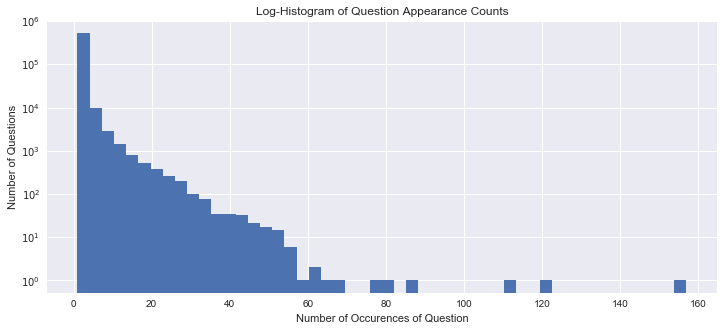

In [6]:
###
# Note: The following notebook was referenced when preparing the approach to data analysis activities below:
# https://www.kaggle.com/anokas/data-analysis-xgboost-starter-0-35460-lb
###

print("Total number of question pairs in the training set: {}".format(len(train_df)))
print('Duplicate pairs: {}%'.format(round(train_df['is_duplicate'].mean()*100, 2)))
qids = pd.Series(train_df['qid1'].tolist() + train_df['qid2'].tolist())
#print qids
print('Total number of unique questions (across both qid1 and qid2) in the training data: {}'.format(len(
    np.unique(qids))))
print('Number of Questions that Appear Multiple Times: {}'.format(np.sum(qids.value_counts() > 1)))

#print(qids.value_counts())

plt.figure(figsize=(12, 5))
plt.hist(qids.value_counts(), bins=50)
plt.yscale('log', nonposy='clip')
plt.title('Log-Histogram of Question Appearance Counts')
plt.xlabel('Number of Occurences of Question')
plt.ylabel('Number of Questions')
print()

**The vast majority of questions either appear once or a few times.** It's possible Quora could have provided every possible unique combination of question (each question compared to every other question) but that would have generated a huge amount of data, and it would be very clear in the majority of cases that questions were not duplicates.

**There is a very small number of questions appearing up to around ~50 times, and three questions that appear over 100 times (111, 120, and 157 times each).** These three questions appear to be outliers.

## Feature Analysis

First, we'll clean up our training questions.
#### Clean Up Text

In [59]:
stops = ['the','a','an','and','but','if','or','because','as','what','which','this','that','these','those','then',
              'just','so','than','such','both','through','about','for','is','of','while','during','to','What','Which',
              'Is','If','While','This']

"""train_q_split = train_q_clean.str.split()
train_q_nostop = train_q_split.apply(lambda x: [item for item in x if item not in stops])
train_q_nostop = train_q_nostop.str.join(' ')"""

"train_q_split = train_q_clean.str.split()\ntrain_q_nostop = train_q_split.apply(lambda x: [item for item in x if item not in stops])\ntrain_q_nostop = train_q_nostop.str.join(' ')"

In [60]:
from string import punctuation
import re

def text_to_wordlist(text, remove_stop_words=False):
    # Clean the text, with the option to remove stop_words and to stem words.

    # Clean the text
    #text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)
    text = re.sub(r"what's", "", text, flags=re.IGNORECASE)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"I'm", "I am", text)
    text = re.sub(r" m ", " am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"60k", " 60000 ", text)
    text = re.sub(r" e g ", " eg ", text)
    text = re.sub(r" b g ", " bg ", text)
    text = re.sub(r"\0s", "0", text)
    text = re.sub(r" 9 11 ", "911", text)
    text = re.sub(r"e-mail", "email", text)
    text = re.sub(r"\s{2,}", " ", text)
    text = re.sub(r"quikly", "quickly", text)
    text = re.sub(r" usa ", " America ", text)
    text = re.sub(r" USA ", " America ", text)
    text = re.sub(r" u s ", " America ", text)
    text = re.sub(r" uk ", " England ", text)
    text = re.sub(r" UK ", " England ", text)
    text = re.sub(r"india", "India", text)
    text = re.sub(r"switzerland", "Switzerland", text)
    text = re.sub(r"china", "China", text)
    text = re.sub(r"chinese", "Chinese", text) 
    text = re.sub(r"imrovement", "improvement", text)
    text = re.sub(r"intially", "initially", text)
    text = re.sub(r"quora", "Quora", text)
    text = re.sub(r" dms ", "direct messages ", text)  
    text = re.sub(r"demonitization", "demonetization", text) 
    text = re.sub(r"actived", "active", text)
    text = re.sub(r"kms", " kilometers ", text)
    text = re.sub(r"KMs", " kilometers ", text)
    text = re.sub(r" cs ", " computer science ", text) 
    text = re.sub(r" upvotes ", " up votes ", text)
    text = re.sub(r" iPhone ", " phone ", text)
    text = re.sub(r"\0rs ", " rs ", text) 
    text = re.sub(r"calender", "calendar", text)
    text = re.sub(r"ios", "operating system", text)
    text = re.sub(r"gps", "GPS", text)
    text = re.sub(r"gst", "GST", text)
    text = re.sub(r"programing", "programming", text)
    text = re.sub(r"bestfriend", "best friend", text)
    text = re.sub(r"dna", "DNA", text)
    text = re.sub(r"III", "3", text) 
    text = re.sub(r"the US", "America", text)
    text = re.sub(r"Astrology", "astrology", text)
    text = re.sub(r"Method", "method", text)
    text = re.sub(r"Find", "find", text) 
    text = re.sub(r"banglore", "Banglore", text)
    text = re.sub(r" J K ", " JK ", text)
    
    # Optionally, remove stop words
    if remove_stop_words:
        text = text.split()
        text = [w for w in text if not w in stops]
        text = " ".join(text)
        
    return text

In [61]:
def process_questions(question_list, questions, question_list_name, dataframe):
    '''transform questions and display progress'''
    for question in questions:
        question_list.append(text_to_wordlist(question))
        if len(question_list) % 100000 == 0:
            progress = len(question_list)/len(dataframe) * 100
            print("{} is {}% complete.".format(question_list_name, round(progress, 1)))

In [65]:
train_question1 = []
process_questions(train_question1, train_df.question1, 'train_question1', train_df)

train_question1 is 24.7% complete.
train_question1 is 49.5% complete.
train_question1 is 74.2% complete.
train_question1 is 98.9% complete.


In [64]:
train_question2 = []
process_questions(train_question2, train_df.question2.astype(str), 'train_question2', train_df)

train_question2 is 24.7% complete.
train_question2 is 49.5% complete.
train_question2 is 74.2% complete.
train_question2 is 98.9% complete.


In [66]:
test_question1 = []
process_questions(test_question1, test_df.question1.astype(str), 'train_question1', test_df)
test_question2 = []
process_questions(test_question2, test_df.question2.astype(str), 'train_question2', test_df)

train_question1 is 4.3% complete.
train_question1 is 8.5% complete.
train_question1 is 12.8% complete.
train_question1 is 17.1% complete.
train_question1 is 21.3% complete.
train_question1 is 25.6% complete.
train_question1 is 29.8% complete.
train_question1 is 34.1% complete.
train_question1 is 38.4% complete.
train_question1 is 42.6% complete.
train_question1 is 46.9% complete.
train_question1 is 51.2% complete.
train_question1 is 55.4% complete.
train_question1 is 59.7% complete.
train_question1 is 63.9% complete.
train_question1 is 68.2% complete.
train_question1 is 72.5% complete.
train_question1 is 76.7% complete.
train_question1 is 81.0% complete.
train_question1 is 85.3% complete.
train_question1 is 89.5% complete.
train_question1 is 93.8% complete.
train_question1 is 98.0% complete.
train_question2 is 4.3% complete.
train_question2 is 8.5% complete.
train_question2 is 12.8% complete.
train_question2 is 17.1% complete.
train_question2 is 21.3% complete.
train_question2 is 25.6%

In [92]:
for i in range(a,a+2):
    print(train_question1[i])
    print(train_question2[i])
    print(train_df['question1'][i])
    print(train_df['question2'][i])
    print()

What is the step by step guide to invest in share market in India?
What is the step by step guide to invest in share market?
What is the step by step guide to invest in share market in India?
What is the step by step guide to invest in share market?

What is the story of Kohinoor (Koh-i-Noor) Diamond?
What would happen if the Indian government stole the Kohinoor (Koh-i-Noor) diamond back?
What is the story of Kohinoor (Koh-i-Noor) Diamond?
What would happen if the Indian government stole the Kohinoor (Koh-i-Noor) diamond back?



In [68]:
train_df['question1'] = train_question1
train_df['question2'] = train_question2
test_df['question1'] = test_question1
test_df['question2'] = test_question2

### Character & Word Counts
Reviewing the character and word counts within questions across both the Training and Test datasets.

In [69]:
train_q = pd.Series(train_df['question1'].tolist() + train_df['question2'].tolist()).astype(str)
test_q = pd.Series(test_df['question1'].tolist() + test_df['question2'].tolist()).astype(str)

char_len_train = train_q.apply(len)
word_len_train = train_q.str.split().apply(len)
#print(char_len_train.head())
#print(word_len_train.head())

char_len_test = test_q.apply(len)
word_len_test = test_q.str.split().apply(len)
#print(char_len_test.head())
#print(word_len_test.head())


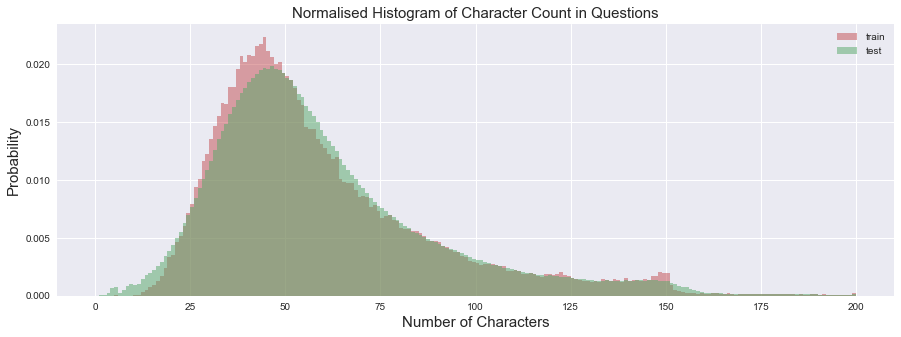

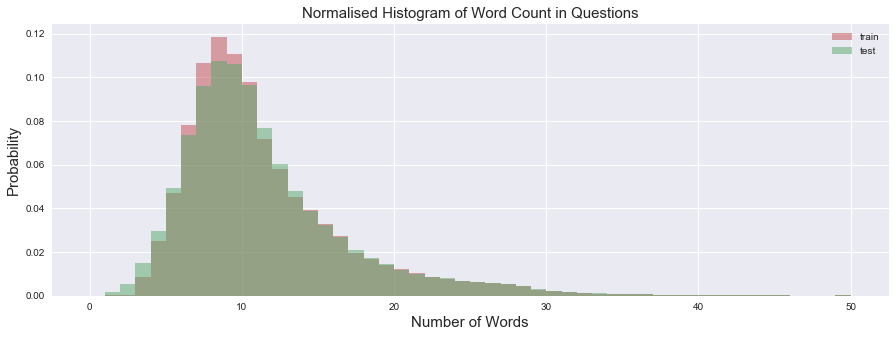

In [70]:
plt.figure(figsize=(15, 5))
plt.hist(char_len_train, bins=200, range=[0, 200], color=pal[2], normed=True, alpha=0.5, label='train')
plt.hist(char_len_test, bins=200, range=[0, 200], color=pal[1], normed=True, alpha=0.5, label='test')
plt.title('Normalised Histogram of Character Count in Questions', fontsize=15)
plt.legend()
plt.xlabel('Number of Characters', fontsize=15)
plt.ylabel('Probability', fontsize=15)

plt.figure(figsize=(15, 5))
plt.hist(word_len_train, bins=50, range=[0, 50], color=pal[2], normed=True, alpha=0.5, label='train')
plt.hist(word_len_test, bins=50, range=[0, 50], color=pal[1], normed=True, alpha=0.5, label='test')
plt.title('Normalised Histogram of Word Count in Questions', fontsize=15)
plt.legend()
plt.xlabel('Number of Words', fontsize=15)
plt.ylabel('Probability', fontsize=15)

#print("Character Count Training Set Analysis")
#print(char_len_train.describe())

#print("\nCharacter Count Testing Set Analysis")
#print(char_len_test.describe())

#print("\nWord Count Training Set Analysis")
#print(word_len_train.describe())

#print("\nWord Count Testing Set Analysis")
#print(word_len_test.describe())

#print('mean-train {:.2f} std-train {:.2f} mean-test {:.2f} std-test {:.2f} max-train {:.2f} max-test {:.2f}'.format(dist_train.mean(), 
#                          dist_train.std(), dist_test.mean(), dist_test.std(), dist_train.max(), dist_test.max()))

### Word Match Sharing
This Stop Words section was adapted from a benchmark model provided in one of the example Kernels provided. We've removed stopwords from the NLTK corpus and compared the remaining words in common from Question 1 with Question 2 and how this relates to whether the questions are duplicate or not.

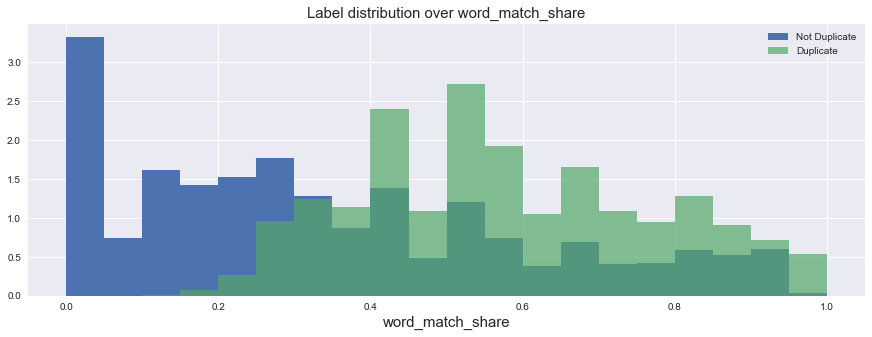

In [71]:
#from nltk.corpus import stopwords

#stops = set(stopwords.words("english"))

def word_match_share(row):
    q1words = {}
    q2words = {}
    for word in str(row['question1']).lower().split():
        if word not in stops:
            q1words[word] = 1
    for word in str(row['question2']).lower().split():
        if word not in stops:
            q2words[word] = 1
    if len(q1words) == 0 or len(q2words) == 0:
        # The computer-generated chaff includes a few questions that are nothing but stopwords
        return 0
    shared_words_in_q1 = [w for w in q1words.keys() if w in q2words]
    shared_words_in_q2 = [w for w in q2words.keys() if w in q1words]
    R = float((len(shared_words_in_q1) + len(shared_words_in_q2)))/float((len(q1words) + len(q2words)))
    return R

plt.figure(figsize=(15, 5))
train_word_match = train_df.apply(word_match_share, axis=1, raw=True)
plt.hist(train_word_match[train_df['is_duplicate'] == 0], bins=20, normed=True, label='Not Duplicate')
plt.hist(train_word_match[train_df['is_duplicate'] == 1], bins=20, normed=True, alpha=0.7, label='Duplicate')
plt.legend()
plt.title('Label distribution over word_match_share', fontsize=15)
plt.xlabel('word_match_share', fontsize=15)

From this Distribution chart we can see that the remaining shared words does have a certain amount of predictive power in terms of whether two questions are duplicate or not. In particular, those question pairs with a score of less than .2 in this word share distribution are all Not Duplicates.  However it's not so great at picking out the Duplicates; for those Question Pairs above .4 we see that there are approximately twice as many Duplicate question pairs as compared to Not Duplicates yet we still see some substantial overlap.

*Sometimes, some extremely common words which would appear to be of little value in helping select documents matching a user need are excluded from the vocabulary entirely. These words are called stop words . The general strategy for determining a stop list is to sort the terms by collection frequency (the total number of times each term appears in the document collection), and then to take the most frequent terms, often hand-filtered for their semantic content relative to the domain of the documents being indexed, as a stop list , the members of which are then discarded during indexing.*

## Label Distribution over Word Count / Char Count

In [72]:
train_df['q1len'] = train_df['question1'].str.len()
train_df['q2len'] = train_df['question2'].str.len()
train_df['q1_n_words'] = train_df['question1'].astype(str).apply(lambda row: len(row.split(" ")))
train_df['q2_n_words'] = train_df['question2'].astype(str).apply(lambda row: len(row.split(" ")))

train_df['char_delta'] = ((train_df['q1len']-train_df['q2len'])**2)
train_df['char_delta'] = (train_df['char_delta'] - np.mean(train_df['char_delta']))/np.std(train_df['char_delta'])

train_df['word_delta'] = ((train_df['q1_n_words']-train_df['q2_n_words'])**2)
train_df['word_delta'] = (train_df['word_delta'] - np.mean(train_df['word_delta']))/np.std(train_df['word_delta'])

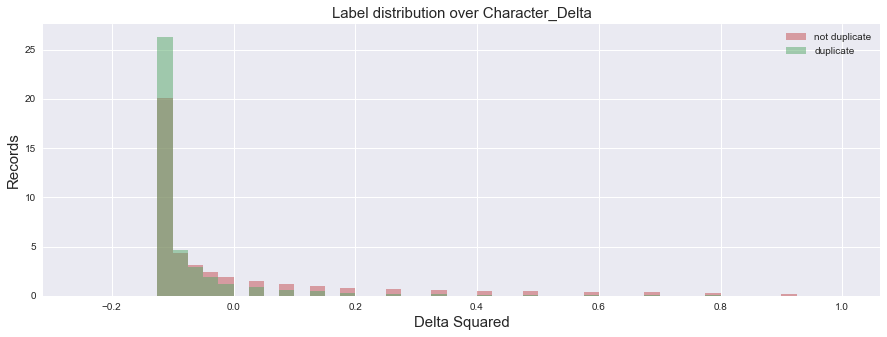

In [103]:
plt.figure(figsize=(15, 5))
plt.hist(train_df[train_df['is_duplicate']== 0]['word_delta'], bins=50, range=[-.25, 1], color=pal[2], normed=True, alpha=0.5, label='not duplicate')
plt.hist(train_df[train_df['is_duplicate']== 1]['word_delta'], bins=50, range=[-.25, 1], color=pal[1], normed=True, alpha=0.5, label='duplicate')
plt.title('Label distribution over Character_Delta', fontsize=15)
plt.legend()
plt.xlabel('Delta Squared', fontsize=15)
plt.ylabel('Records', fontsize=15)

In [74]:
from sklearn.metrics import roc_auc_score
print('word_delta AUC:', roc_auc_score(train_df['is_duplicate'], train_df['word_delta']))
print('char_delta AUC:', roc_auc_score(train_df['is_duplicate'], train_df['char_delta']))

word_delta AUC: 0.390389887722
char_delta AUC: 0.381625732045


We can see that the duplicate questions tend to have a smaller delta of characters and words comparing to the questions which are not duplicate. I don't know that we necessarily need to use both of these features; we could consider combining them and taking an average to incorporate both bits of information, and additionally we could consider removing stop words and punctuation to see if that provides an added benefit.

**Now I'm going to create the Word and Char Delta Characters for the Test Set.**

In [75]:
# creating word count variables for our test set
test_df['q1len'] = test_df['question1'].str.len()
test_df['q2len'] = test_df['question2'].str.len()
test_df['q1_n_words'] = test_df['question1'].astype(str).apply(lambda row: len(row.split(" ")))
test_df['q2_n_words'] = test_df['question2'].astype(str).apply(lambda row: len(row.split(" ")))

test_df['char_delta'] = ((test_df['q1len']-test_df['q2len'])**2)
test_df['char_delta'] = (test_df['char_delta'] - np.mean(test_df['char_delta']))/np.std(test_df['char_delta'])

test_df['word_delta'] = ((test_df['q1_n_words']-test_df['q2_n_words'])**2)
test_df['word_delta'] = (test_df['word_delta'] - np.mean(test_df['word_delta']))/np.std(test_df['word_delta'])
test_df.head()

,test_id,question1,question2,q1len,q2len,q1_n_words,q2_n_words,char_delta,word_delta
0,0,How does the Surface Pro himself 4 compare wit...,Why did Microsoft choose core m3 and not core ...,57,68,11,14,-0.267982,-0.209098
1,1,Should I have a hair transplant at age 24? How...,How much cost does hair transplant require?,66,43,14,7,-0.169202,0.043875
2,2,What but is the best way to send money from Ch...,What you send money to China?,61,29,13,6,-0.049358,0.043875
3,3,Which food not emulsifiers?,What foods fibre?,27,17,4,3,-0.273066,-0.259693
4,4,"How ""aberystwyth"" start reading?",How their can I start reading?,32,30,4,6,-0.296308,-0.240720


## Levenshtein Ratio
Calculating Levenstein ratio over the two strings...

In [99]:
import Levenshtein as lev

t = []
for r in zip(train_df['question1'], train_df['question2']):
    t.append(lev.ratio(r[0], r[1]))
train_df['lev_ratio'] = t

t = []
for r in zip(test_df['question1'], test_df['question2']):
    t.append(lev.ratio(r[0], r[1]))
test_df['lev_ratio'] = t

del t

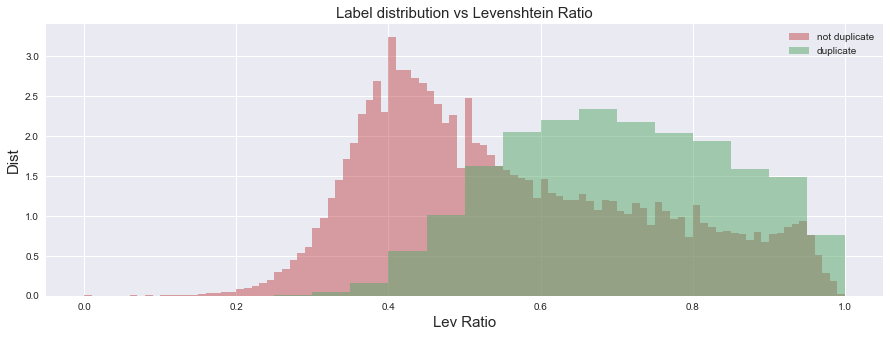

In [106]:
plt.figure(figsize=(15, 5))
plt.hist(train_df[train_df['is_duplicate']== 0]['lev_ratio'], bins=100, range=[0, 1], color=pal[2], normed=True, alpha=0.5, label='not duplicate')
plt.hist(train_df[train_df['is_duplicate']== 1]['lev_ratio'], bins=20, range=[0, 1], color=pal[1], normed=True, alpha=0.5, label='duplicate')
plt.title('Label distribution vs Levenshtein Ratio', fontsize=15)
plt.legend()
plt.xlabel('Lev Ratio', fontsize=15)
plt.ylabel('Dist', fontsize=15)

### TF-IDF
Let's test out TF-IDF (Term Frequency - Inverse Document Frequency) which allows us to weigh the terms by how uncommon they are. This puts value on rare words that exist in both questions as opposed to common words. 

#### Get Term Frequency

In [76]:
from collections import Counter

# If a word appears only once, we ignore it completely (likely a typo)
# Epsilon defines a smoothing constant, which makes the effect of extremely rare words smaller
def get_weight(count, eps=10000, min_count=2):
    if count < min_count:
        return 0
    else:
        return 1 / (count + eps)

eps = 5000 
words = (" ".join(train_q)).lower().split()
counts = Counter(words)
weights = {word: get_weight(count) for word, count in counts.items()}

In [77]:
print('Most common words and weights: \n')
print(sorted(weights.items(), key=lambda x: x[1] if x[1] > 0 else 9999)[:10])
print('\nLeast common words and weights: ')
(sorted(weights.items(), key=lambda x: x[1], reverse=True)[:10])

Most common words and weights: 

[('the', 2.6210739588438968e-06), ('what', 3.1153230278447572e-06), ('is', 3.5700005712000914e-06), ('i', 4.338112487256794e-06), ('how', 4.363915654238235e-06), ('a', 4.540274504996572e-06), ('to', 4.671412822093914e-06), ('in', 4.884625153865692e-06), ('do', 5.788678502584645e-06), ('of', 5.920242493132519e-06)]

Least common words and weights: 


[('chameleons', 9.998000399920016e-05),
 ('275', 9.998000399920016e-05),
 ('276', 9.998000399920016e-05),
 ('kid:', 9.998000399920016e-05),
 ('usenet', 9.998000399920016e-05),
 ('(football', 9.998000399920016e-05),
 ('dittofish?', 9.998000399920016e-05),
 ('sneha', 9.998000399920016e-05),
 ('population)', 9.998000399920016e-05),
 (',delhi', 9.998000399920016e-05)]

In [78]:
def tfidf_word_match_share(row):
    q1words = {}
    q2words = {}
    for word in str(row['question1']).lower().split():
        if word not in stops:
            q1words[word] = 1
    for word in str(row['question2']).lower().split():
        if word not in stops:
            q2words[word] = 1
    if len(q1words) == 0 or len(q2words) == 0:
        # The computer-generated chaff includes a few questions that are nothing but stopwords
        return 0
    
    shared_weights = [weights.get(w, 0) for w in q1words.keys() if w in q2words] + [weights.get(w, 0) for w in q2words.keys() if w in q1words]
    total_weights = [weights.get(w, 0) for w in q1words] + [weights.get(w, 0) for w in q2words]
    
    R = np.sum(shared_weights) / np.sum(total_weights)
    return R

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:17: RuntimeWarning: invalid value encountered in double_scalars


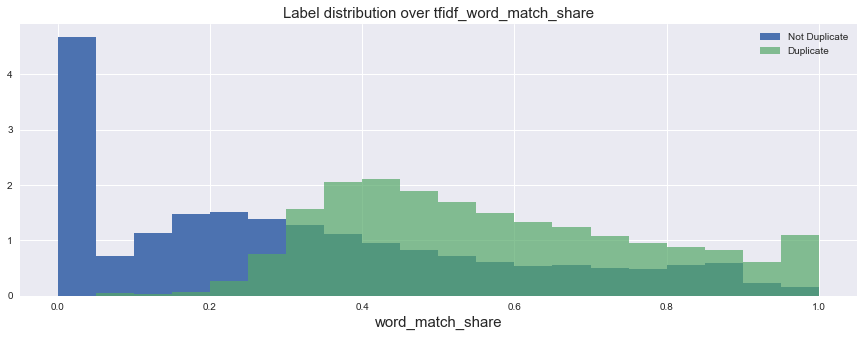

In [79]:
plt.figure(figsize=(15, 5))
tfidf_train_word_match = train_df.apply(tfidf_word_match_share, axis=1, raw=True)
plt.hist(tfidf_train_word_match[train_df['is_duplicate'] == 0].fillna(0), bins=20, normed=True, label='Not Duplicate')
plt.hist(tfidf_train_word_match[train_df['is_duplicate'] == 1].fillna(0), bins=20, normed=True, alpha=0.7, label='Duplicate')
plt.legend()
plt.title('Label distribution over tfidf_word_match_share', fontsize=15)
plt.xlabel('word_match_share', fontsize=15)

In [80]:
from sklearn.metrics import roc_auc_score
print('Original AUC:', roc_auc_score(train_df['is_duplicate'], train_word_match))
print('   TFIDF AUC:', roc_auc_score(train_df['is_duplicate'], tfidf_train_word_match.fillna(0)))

Original AUC: 0.765292542174
   TFIDF AUC: 0.772832949885





## Testing NLP Techniques



In [14]:
import time
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

from sklearn import model_selection
from sklearn import linear_model

from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss
from sklearn.metrics import roc_auc_score

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

matplotlib.style.use('fivethirtyeight')

In [15]:
#%% create dictionary and extract BOW features from questions

featureExtractionStartTime = time.time()

maxNumFeatures = 300000

# bag of letter sequences (chars)
BagOfWordsExtractor = CountVectorizer(max_df=0.999, min_df=50, max_features=maxNumFeatures, 
                                      analyzer='char', ngram_range=(1,10), 
                                      binary=True, lowercase=True)
# bag of words
#BagOfWordsExtractor = CountVectorizer(max_df=0.999, min_df=10, max_features=maxNumFeatures, 
#                                      analyzer='word', ngram_range=(1,6), stop_words='english', 
#                                      binary=True, lowercase=True)

BagOfWordsExtractor.fit(pd.concat((train_df.ix[:,'question1'],train_df.ix[:,'question2'])).unique())

trainQuestion1_BOW_rep = BagOfWordsExtractor.transform(train_df.ix[:,'question1'])
trainQuestion2_BOW_rep = BagOfWordsExtractor.transform(train_df.ix[:,'question2'])
labels = np.array(train_df.ix[:,'is_duplicate'])

featureExtractionDurationInMinutes = (time.time()-featureExtractionStartTime)/60.0
print("feature extraction took %.2f minutes" % (featureExtractionDurationInMinutes))

feature extraction took 26.09 minutes


In [16]:
0#%% prefrom cross validation

crossValidationStartTime = time.time()

numCVSplits = 8
numSplitsToBreakAfter = 2

X = -(trainQuestion1_BOW_rep != trainQuestion2_BOW_rep).astype(int)
#X = -(trainQuestion1_BOW_rep != trainQuestion2_BOW_rep).astype(int) + \
#      trainQuestion1_BOW_rep.multiply(trainQuestion2_BOW_rep)
y = labels

logisticRegressor = linear_model.LogisticRegression(C=0.1, solver='sag')

logRegAccuracy = []
logRegLogLoss = []
logRegAUC = []

print('---------------------------------------------')
stratifiedCV = model_selection.StratifiedKFold(n_splits=numCVSplits, random_state=2)
for k, (trainInds, validInds) in enumerate(stratifiedCV.split(X, y)):
    foldTrainingStartTime = time.time()

    X_train_cv = X[trainInds,:]
    X_valid_cv = X[validInds,:]

    y_train_cv = y[trainInds]
    y_valid_cv = y[validInds]

    logisticRegressor.fit(X_train_cv, y_train_cv)

    y_train_hat =  logisticRegressor.predict_proba(X_train_cv)[:,1]
    y_valid_hat =  logisticRegressor.predict_proba(X_valid_cv)[:,1]

    logRegAccuracy.append(accuracy_score(y_valid_cv, y_valid_hat > 0.5))
    logRegLogLoss.append(log_loss(y_valid_cv, y_valid_hat))
    logRegAUC.append(roc_auc_score(y_valid_cv, y_valid_hat))
    
    foldTrainingDurationInMinutes = (time.time()-foldTrainingStartTime)/60.0
    print('fold %d took %.2f minutes: accuracy = %.3f, log loss = %.4f, AUC = %.3f' % (k+1,
             foldTrainingDurationInMinutes, logRegAccuracy[-1],logRegLogLoss[-1],logRegAUC[-1]))

    if (k+1) >= numSplitsToBreakAfter:
        break


crossValidationDurationInMinutes = (time.time()-crossValidationStartTime)/60.0

print('---------------------------------------------')
print('cross validation took %.2f minutes' % (crossValidationDurationInMinutes))
print('mean CV: accuracy = %.3f, log loss = %.4f, AUC = %.3f' % (np.array(logRegAccuracy).mean(),
                                                                 np.array(logRegLogLoss).mean(),
                                                                 np.array(logRegAUC).mean()))
print('---------------------------------------------')

---------------------------------------------


/usr/local/lib/python2.7/site-packages/sklearn/linear_model/sag.py:286: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


fold 1 took 8.23 minutes: accuracy = 0.847, log loss = 0.3518, AUC = 0.919
fold 2 took 7.11 minutes: accuracy = 0.844, log loss = 0.3553, AUC = 0.917
---------------------------------------------
cross validation took 15.63 minutes
mean CV: accuracy = 0.845, log loss = 0.3536, AUC = 0.918
---------------------------------------------


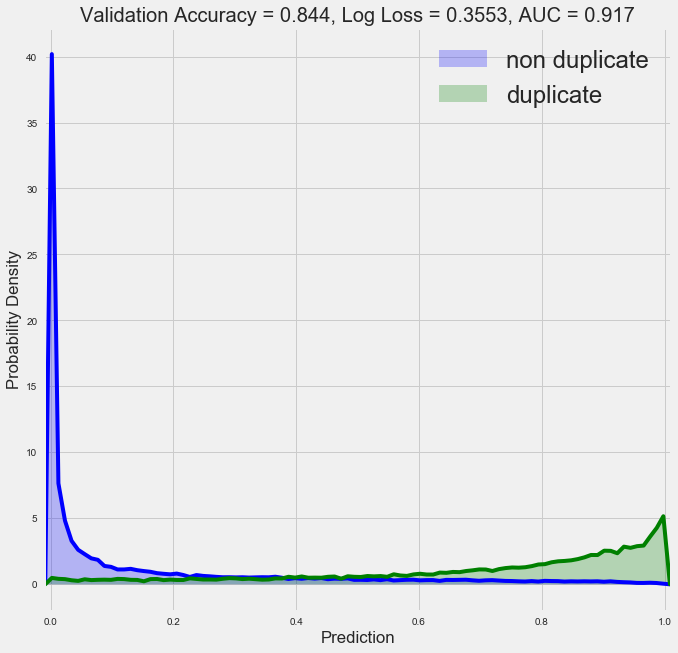

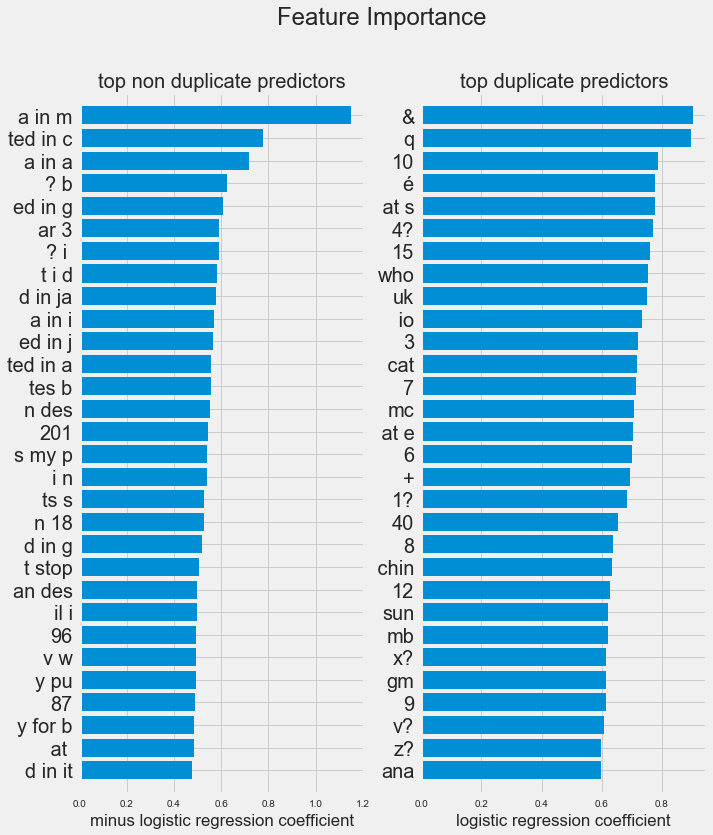

In [17]:
9#%% show prediction distribution and "feature importance"

matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['figure.figsize'] = (10,10)

plt.figure(); 
sns.kdeplot(y_valid_hat[y_valid_cv==0], shade=True, color="b", bw=0.01)
sns.kdeplot(y_valid_hat[y_valid_cv==1], shade=True, color="g", bw=0.01)
plt.legend(['non duplicate','duplicate'],fontsize=24)
plt.title('Validation Accuracy = %.3f, Log Loss = %.4f, AUC = %.3f' %(logRegAccuracy[-1],
                                                                      logRegLogLoss[-1],
                                                                      logRegAUC[-1]))
plt.xlabel('Prediction'); plt.ylabel('Probability Density'); plt.xlim(-0.01,1.01)


numFeaturesToShow = 30

sortedCoeffients = np.sort(logisticRegressor.coef_)[0]
featureNames = BagOfWordsExtractor.get_feature_names()
sortedFeatureNames = [featureNames[x] for x in list(np.argsort(logisticRegressor.coef_)[0])]

matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['figure.figsize'] = (10,12)

plt.figure()
plt.suptitle('Feature Importance',fontsize=24)
ax = plt.subplot(1,2,1); plt.title('top non duplicate predictors'); 
plt.xlabel('minus logistic regression coefficient')
ax.barh(range(numFeaturesToShow), -sortedCoeffients[:numFeaturesToShow][::-1], align='center'); 
plt.ylim(-1,numFeaturesToShow); ax.set_yticks(range(numFeaturesToShow)); 
ax.set_yticklabels(sortedFeatureNames[:numFeaturesToShow][::-1],fontsize=20)

ax = plt.subplot(1,2,2); plt.title('top duplicate predictors'); 
plt.xlabel('logistic regression coefficient')
ax.barh(range(numFeaturesToShow), sortedCoeffients[-numFeaturesToShow:], align='center'); 
plt.ylim(-1,numFeaturesToShow); ax.set_yticks(range(numFeaturesToShow)); 
ax.set_yticklabels(sortedFeatureNames[-numFeaturesToShow:],fontsize=20)

In [18]:
#%% train on full training data

trainingStartTime = time.time()

logisticRegressor = linear_model.LogisticRegression(C=0.1, solver='sag', 
                                                    class_weight={1: 0.46, 0: 1.32})
logisticRegressor.fit(X, y)

trainingDurationInMinutes = (time.time()-trainingStartTime)/60.0
print('full training took %.2f minutes' % (trainingDurationInMinutes))

full training took 7.00 minutes


predicting on test took 64.24 minutes


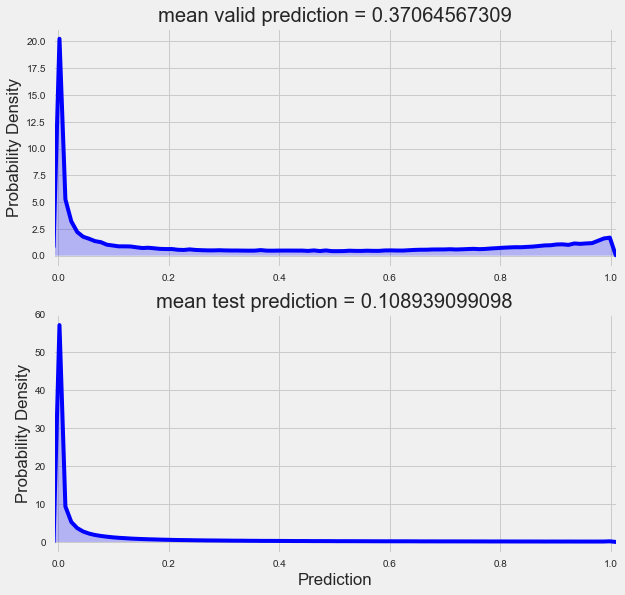

In [19]:
0#%% load test data, extract features and make predictions

testPredictionStartTime = time.time()

#testDF = pd.read_csv('../input/test.csv')
test_df.ix[test_df['question1'].isnull(),['question1','question2']] = 'random empty question'
test_df.ix[test_df['question2'].isnull(),['question1','question2']] = 'random empty question'

testQuestion1_BOW_rep = BagOfWordsExtractor.transform(test_df.ix[:,'question1'])
testQuestion2_BOW_rep = BagOfWordsExtractor.transform(test_df.ix[:,'question2'])

X_test = -(testQuestion1_BOW_rep != testQuestion2_BOW_rep).astype(int)
#X_test = -(testQuestion1_BOW_rep != testQuestion2_BOW_rep).astype(int) + \
#           testQuestion1_BOW_rep.multiply(testQuestion2_BOW_rep)

testPredictions = logisticRegressor.predict_proba(X_test)[:,1]

# quick fix to avoid memory errors
#seperators= [750000,1500000]
#testPredictions1 = logisticRegressor.predict_proba(X_test[:seperators[0],:])[:,1]
#testPredictions2 = logisticRegressor.predict_proba(X_test[seperators[0]:seperators[1],:])[:,1]
#testPredictions3 = logisticRegressor.predict_proba(X_test[seperators[1]:,:])[:,1]
#testPredictions = np.hstack((testPredictions1,testPredictions2,testPredictions3))

matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['figure.figsize'] = (9,9)

plt.figure(); 
plt.subplot(2,1,1); sns.kdeplot(y_valid_hat, shade=True, color="b", bw=0.01); 
plt.ylabel('Probability Density'); plt.xlim(-0.01,1.01)
plt.title('mean valid prediction = ' + str(np.mean(y_valid_hat)))
plt.subplot(2,1,2); sns.kdeplot(testPredictions, shade=True, color="b", bw=0.01);
plt.xlabel('Prediction'); plt.ylabel('Probability Density'); plt.xlim(-0.01,1.01)
plt.title('mean test prediction = ' + str(np.mean(testPredictions)))

testPredictionDurationInMinutes = (time.time()-testPredictionStartTime)/60.0
print('predicting on test took %.2f minutes' % (testPredictionDurationInMinutes))

In [20]:
print(len(test_df['test_id']))

2345796


In [21]:
#%% create a submission

submissionName = 'shallowBenchmark_ph2'

submission = pd.DataFrame()
submission['test_id'] = test_df['test_id']
submission['is_duplicate'] = testPredictions
submission.to_csv(submissionName + '.csv', index=False)

## Rebalancing the Data
This section was taken from: https://www.kaggle.com/anokas/data-analysis-xgboost-starter-0-35460-lb

In [116]:
# First we create our training and testing data
x_train = pd.DataFrame()
x_test = pd.DataFrame()
x_train['word_match'] = train_word_match
x_train['tfidf_word_match'] = tfidf_train_word_match
x_test['word_match'] = test_df.apply(word_match_share, axis=1, raw=True)
x_test['tfidf_word_match'] = test_df.apply(tfidf_word_match_share, axis=1, raw=True)

# adding word_delta & char_delta variables
#x_train['word_delta'] = train_df['word_delta']
#x_train['char_delta'] = train_df['char_delta']
#x_test['word_delta'] = test_df['word_delta']
#x_test['char_delta'] = test_df['char_delta']

# adding levenshtein ratios
x_train['lev_ratio'] = train_df['lev_ratio']
x_train['lev_ratio'] = train_df['lev_ratio']
x_test['lev_ratio'] = test_df['lev_ratio']
x_test['lev_ratio'] = test_df['lev_ratio']

y_train = train_df['is_duplicate'].values

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:17: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:17: RuntimeWarning: invalid value encountered in long_scalars


In [2]:
pos_train = x_train[y_train == 1]
neg_train = x_train[y_train == 0]

# Now we oversample the negative class
# There is likely a much more elegant way to do this...
p = 0.165
scale = ((len(pos_train) / (len(pos_train) + len(neg_train))) / p) - 1
while scale > 1:
    neg_train = pd.concat([neg_train, neg_train])
    scale -=1
neg_train = pd.concat([neg_train, neg_train[:int(scale * len(neg_train))]])
print(len(pos_train) / (len(pos_train) + len(neg_train)))

x_train = pd.concat([pos_train, neg_train])
y_train = (np.zeros(len(pos_train)) + 1).tolist() + np.zeros(len(neg_train)).tolist()
del pos_train, neg_train

NameError: name 'x_train' is not defined

In [118]:
# Finally, we split some of the data off for validation
from sklearn.cross_validation import train_test_split

x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.2, random_state=4242)

In [119]:
x_train.head()

,word_match,tfidf_word_match,lev_ratio
328775,0.235294,0.197051,0.500000
262349,0.600000,0.456882,0.794521
337320,0.181818,0.275366,0.351351
21922,0.307692,0.426974,0.544118
40069,0.444444,0.527737,0.700000


## XGBoost
Now we can finally run XGBoost on our data, in order to see the score on the leaderboard!

In [143]:
import xgboost as xgb

# Set our parameters for xgboost
params = {}
params['objective'] = 'binary:logistic'
params['eval_metric'] = 'logloss'
params['eta'] = 0.2
params['max_depth'] = 4
params['min_child_weight'] = 1
params['seed']=27
#params['gamma'] = 0.01
#params['subsample'] = 0.8
#params['colsample_bytree'] = 0.8
#params['scale_pos_weight'] = 1

d_train = xgb.DMatrix(x_train, label=y_train)
d_valid = xgb.DMatrix(x_valid, label=y_valid)

watchlist = [(d_train, 'train'), (d_valid, 'valid')]

bst = xgb.train(params, d_train, 400, watchlist, early_stopping_rounds=50, verbose_eval=10)

[0]	train-logloss:0.603493	valid-logloss:0.60408
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 50 rounds.
[10]	train-logloss:0.386682	valid-logloss:0.389493
[20]	train-logloss:0.367995	valid-logloss:0.371255
[30]	train-logloss:0.364765	valid-logloss:0.368077
[40]	train-logloss:0.363067	valid-logloss:0.366274
[50]	train-logloss:0.361746	valid-logloss:0.364986
[60]	train-logloss:0.360826	valid-logloss:0.364119
[70]	train-logloss:0.360117	valid-logloss:0.363609
[80]	train-logloss:0.359316	valid-logloss:0.362896
[90]	train-logloss:0.358887	valid-logloss:0.362597
[100]	train-logloss:0.358496	valid-logloss:0.362319
[110]	train-logloss:0.358306	valid-logloss:0.362217
[120]	train-logloss:0.357837	valid-logloss:0.361908
[130]	train-logloss:0.357408	valid-logloss:0.361638
[140]	train-logloss:0.357073	valid-logloss:0.361382
[150]	train-logloss:0.356739	valid-logloss:0.361132
[160]	train-logloss:0.356395	

In [144]:
d_test = xgb.DMatrix(x_test)
p_test = bst.predict(d_test)

sub = pd.DataFrame()
sub['test_id'] = test_df['test_id']
sub['is_duplicate'] = p_test
sub.to_csv('simple_xgb_ph3_9-may-2017.csv', index=False)

In [145]:
sub.head()

,test_id,is_duplicate
0,0,0.007467
1,1,0.314682
2,2,0.362530
3,3,0.000141
4,4,0.308862


In [126]:
log_loss(y_valid, y_pred)

6.4175283310628357